## Libraries to Install

In [1]:
# !pip install yfinance
# !pip install pmdarima
# !pip install statsmodels

## Import Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("figure", figsize=(20,5))
import seaborn as sns

from datetime import datetime

# To import the dataset
import yfinance as yf

# To suppress all warnings
import warnings
warnings.filterwarnings("ignore")

## Import Dataset

In [4]:
stock_name = 'AMZN' # Amazon dataset from Yahoo-Finance

end = datetime.now()
start = datetime(end.year - 1, end.month, end.day) 

stock = yf.download(stock_name, start, end) # Data of past 1 Year

[*********************100%%**********************]  1 of 1 completed


In [5]:
stock.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-07-17,134.559998,135.619995,133.210007,133.559998,133.559998,48450200
2023-07-18,132.710007,133.860001,131.350006,132.830002,132.830002,54969100
2023-07-19,133.389999,135.990005,132.529999,135.360001,135.360001,54531000
2023-07-20,134.070007,134.789993,129.330002,129.960007,129.960007,59820600
2023-07-21,131.339996,131.369995,128.419998,130.000000,130.000000,133265000


# ARIMA Model For Stock Prediction : ARIMA(p,d,q)

## Stationarity

In [6]:
# Adjusted Dickey-Fuller Test (ADF Test)
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistics : {result[0]}')
    print(f'P-Value : {result[1]}')
    if result[1] <=0.05:
        print("Stationary")
    else:
        print("Non-Stationary")

In [7]:
adf_test(stock["Adj Close"])

ADF Statistics : -0.3215982787367366
P-Value : 0.922389177892765
Non-Stationary


In [8]:
df_adj_Close = stock["Adj Close"].to_frame()
df_adj_Close.head()

,Adj Close
Date,
2023-07-17,133.559998
2023-07-18,132.830002
2023-07-19,135.360001
2023-07-20,129.960007
2023-07-21,130.000000


# ARIMA Model : d

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

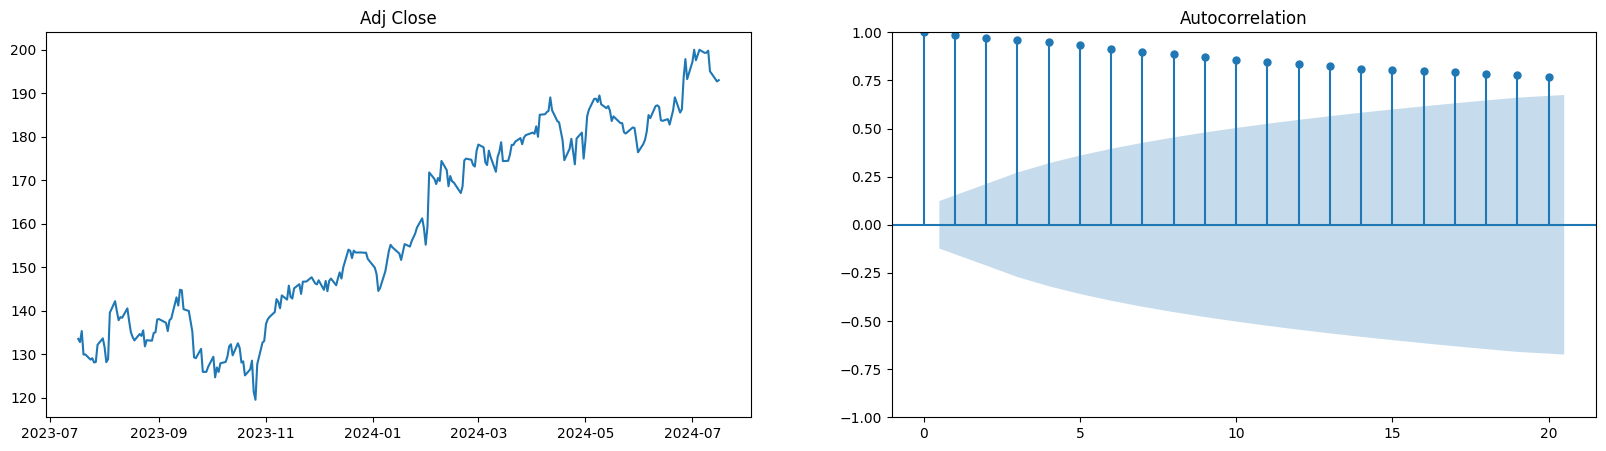

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,5))

ax1.plot(df_adj_Close['Adj Close'])
ax1.set_title('Adj Close')

plot_acf(df_adj_Close['Adj Close'], lags=20, ax=ax2)

plt.show()

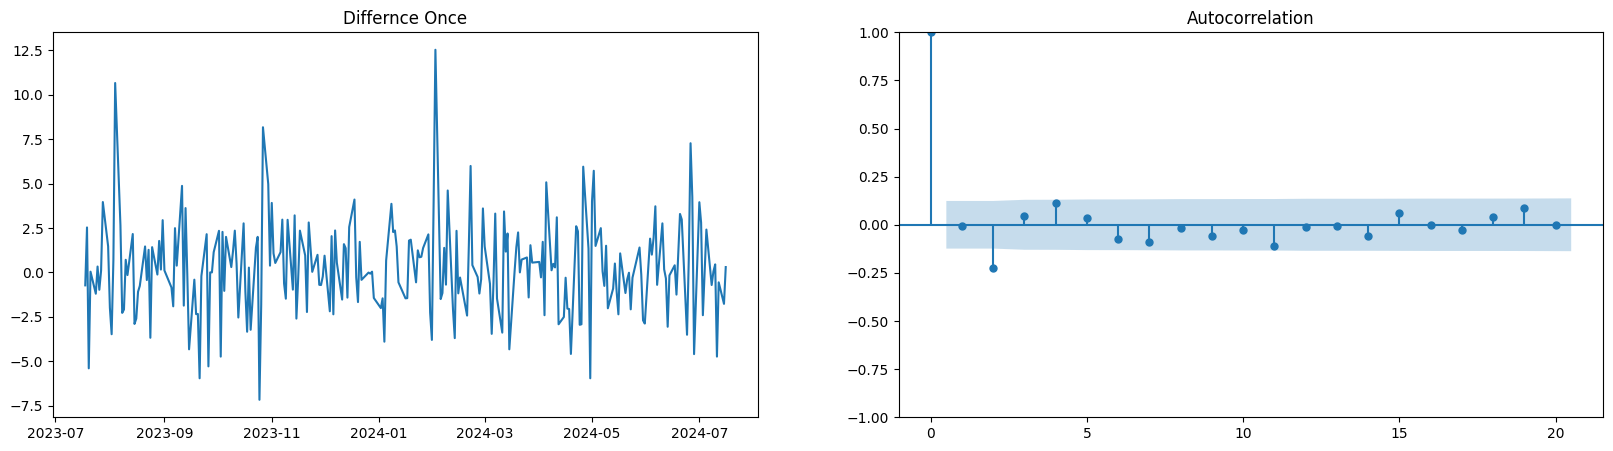

In [11]:
diff_ = df_adj_Close['Adj Close'].diff().dropna()

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,5))

ax1.plot(diff_)
ax1.set_title('Differnce Once')

plot_acf(diff_, lags=20, ax=ax2)

plt.show()

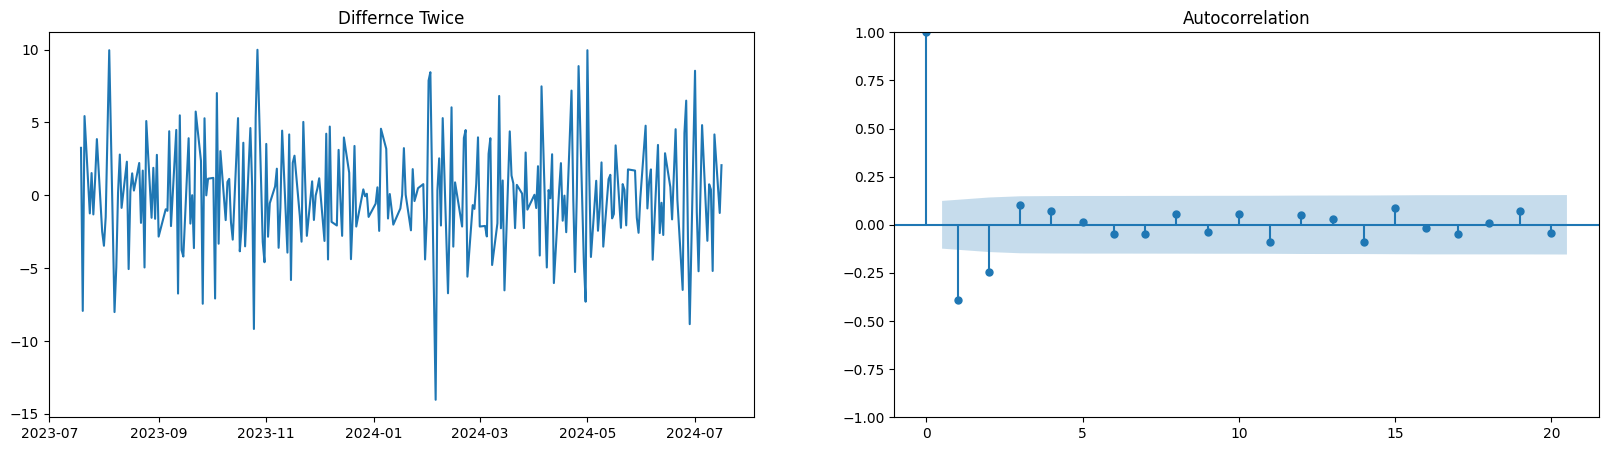

In [12]:
diff_ = df_adj_Close['Adj Close'].diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,5))

ax1.plot(diff_)
ax1.set_title('Differnce Twice')

plot_acf(diff_, lags=20, ax=ax2)

plt.show()

In [13]:
from pmdarima.arima.utils import ndiffs
ndiffs(df_adj_Close['Adj Close'], test = 'adf')

1

## ARIMA Model : p  -- (AutoRegressive Term)

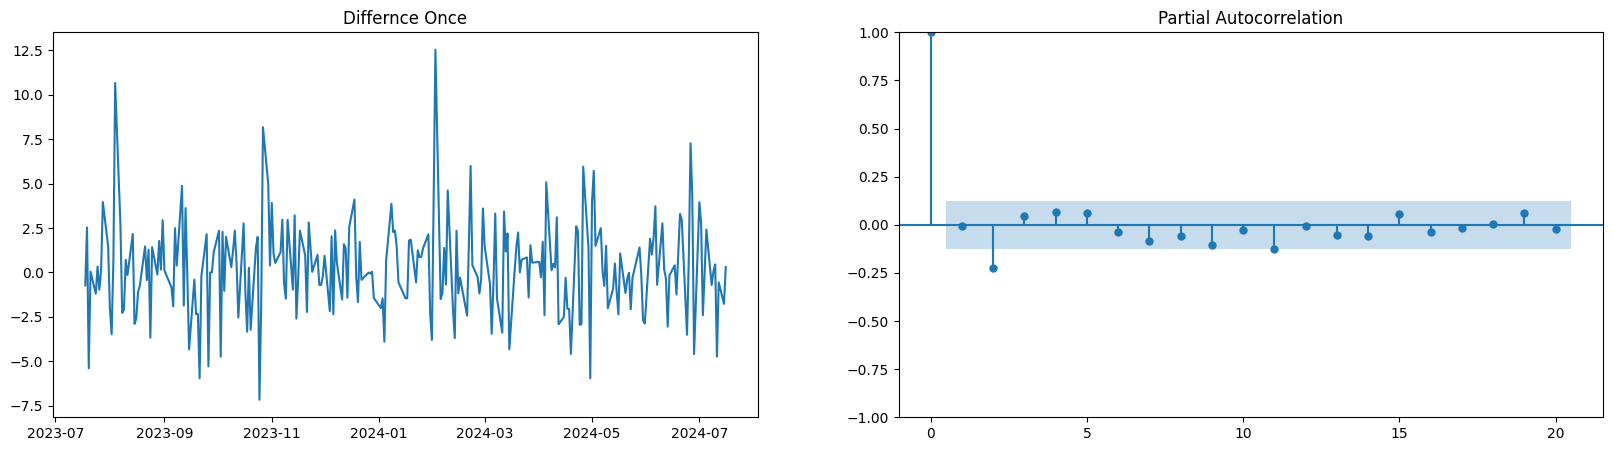

In [14]:
diff_ = df_adj_Close['Adj Close'].diff().dropna()

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,5))

ax1.plot(diff_)
ax1.set_title('Differnce Once')

plot_pacf(diff_, lags=20, ax=ax2)

plt.show()

## ARIMA Model : q -- (Moving Avg.)

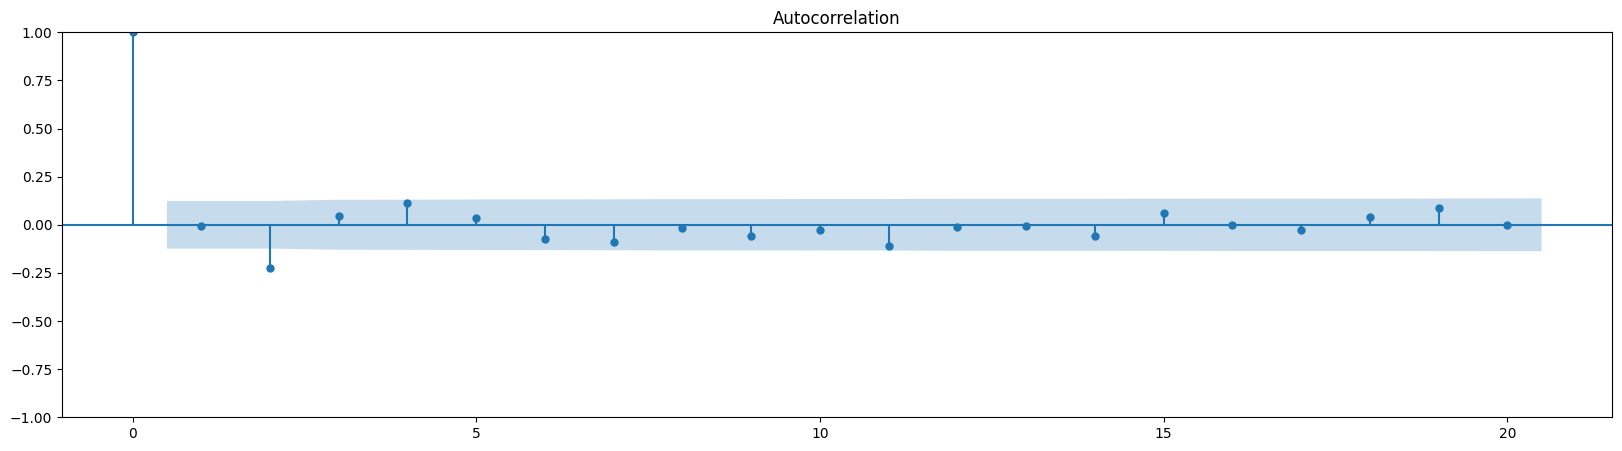

In [15]:
diff_ = df_adj_Close['Adj Close'].diff().dropna()

plot_acf(diff_, lags=20)
plt.show()

## Split data into train and test sets

In [16]:
X = df_adj_Close['Adj Close'].values
n = int(len(X) * 0.8)

train = X[:n]
test =  X[n:]

In [17]:
len(train)

201

In [18]:
len(test)

51

## Auto-Arima

In [19]:
from pmdarima.arima import auto_arima

# Auto ARIMA to select optimal ARIMA parameters
model = auto_arima(train, test='adf', seasonal=False, trace=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=962.074, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=966.639, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=968.495, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=968.381, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=966.066, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=963.811, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=962.259, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=963.474, Time=0.60 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=963.501, Time=0.56 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=966.953, Time=0.24 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=965.025, Time=0.32 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=964.068, Time=0.69 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=965.462, Time=1.47 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=962.259, Time=0.16 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept


## ARIMA Model

In [20]:
from statsmodels.tsa.arima.model import ARIMA

# Fit the model
model = ARIMA(train, order=(2,1,2))
result = model.fit()

In [21]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  201
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -476.129
Date:                Tue, 16 Jul 2024   AIC                            962.259
Time:                        20:10:38   BIC                            978.750
Sample:                             0   HQIC                           968.933
                                - 201                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2642      0.236      1.120      0.263      -0.198       0.727
ar.L2         -0.6572      0.243     -2.705      0.007      -1.133      -0.181
ma.L1         -0.3097      0.276     -1.124      0.2

In [22]:
# forecasting
step = len(test)

pred = result.forecast(step)

In [23]:
pd.DataFrame({'Expected' : test, 'Predicted' : pred}).head()

,Expected,Predicted
0,184.720001,180.175627
1,186.210007,180.147036
2,188.699997,179.366903
3,188.759995,179.179560
4,188.000000,179.642733


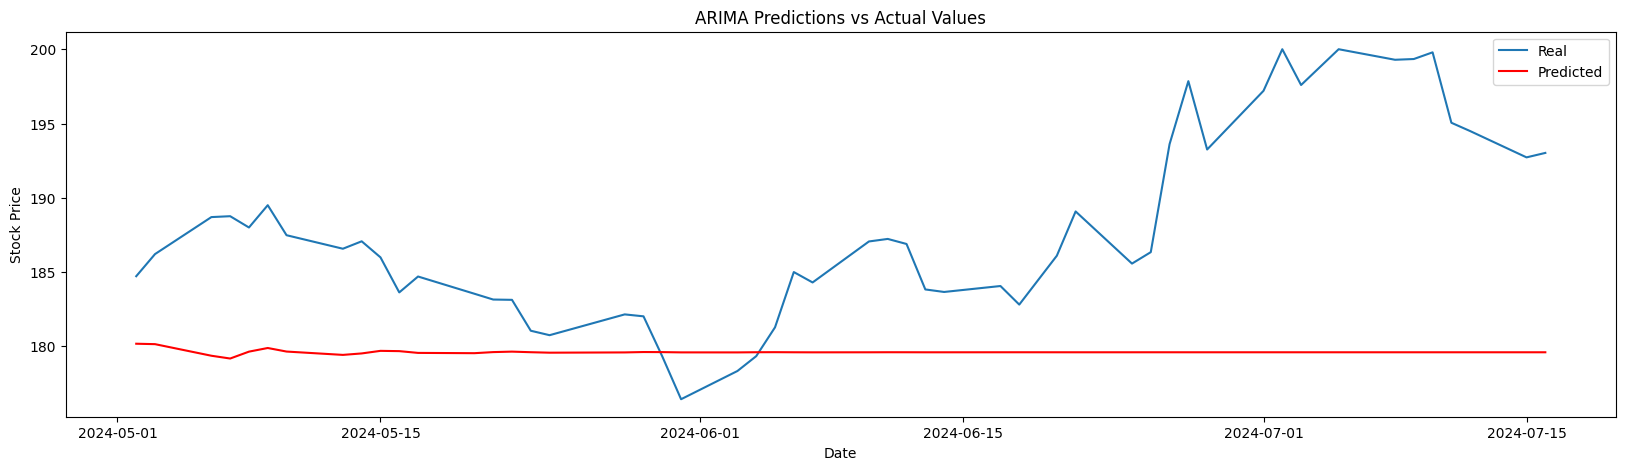

In [24]:
plt.plot(df_adj_Close.iloc[n:,:].index, test, label='Real')
plt.plot(df_adj_Close.iloc[n:,:].index, pred, color='red', label='Predicted')
plt.title('ARIMA Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(test, pred)
print('MSE: '+str(mse))
mae = mean_absolute_error(test, pred)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test, pred))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(pred - test)/np.abs(test))
print('MAPE: '+str(mape))

MSE: 105.79028624811069
MAE: 8.364069291510956
RMSE: 10.28544049849644
MAPE: 0.04356237771790404
